In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [251]:
death_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
deaths_df = pd.read_csv(death_url, error_bad_lines=False)

cases_url =  "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
cases_df = pd.read_csv(cases_url, error_bad_lines=False)

states_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-08-2020.csv"
states_df = pd.read_csv(states_url, error_bad_lines=False)

# county_level = "https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv"
county_df = pd.read_csv('./covid19/small_abridged.csv', error_bad_lines=False)

In [252]:
deaths_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,94,95,97,97,99,99,102,107,108,111
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,4,4,4,4,4,4,4,4,4,4


In [407]:
#drop territories
cases = cases_df[~cases_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
cases = cases[~cases['FIPS'].isnull()] 
#change FIPS to integer type
cases['FIPS'] = cases['FIPS'].astype(int)
#Only dealing with states, so county is better name
cases = cases.rename(columns={'Admin2':'County'}) 
#the country is US, unnecessary
cases = cases.drop(columns=['Country_Region'])
cases.head()

#repeat for deaths

#drop territories
deaths = deaths_df[~deaths_df['Admin2'].isnull()] 
#drop those without FIPS-we thought this is acceptable because most are not actually counties, and there's only 10 of them
deaths = deaths[~deaths['FIPS'].isnull()] 
#change FIPS to integer type
deaths['FIPS'] = deaths['FIPS'].astype(int)
#Only dealing with states, so county is better name
deaths = deaths.rename(columns={'Admin2':'County'})
deaths.head()

county = county_df.rename(columns={'countyFIPS':'FIPS', 'CountyName':'County'}).drop(columns=['Unnamed: 0'])
# drop rows that are not counties. There's only two: NYC and Kansas City, so shouldn't matter much
county = county[county['FIPS'].str.isnumeric()]
county['FIPS'] = county['FIPS'].astype(int)
county.head()

county_cases_deaths = pd.read_csv('county_info_cases_deaths.csv')
county_cases_deaths.head()


,Unnamed: 0,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,...,4/30/20_cases,5/1/20_cases,5/2/20_cases,5/3/20_cases,5/4/20_cases,5/5/20_cases,5/6/20_cases,5/7/20_cases,5/8/20_cases,5/9/20_cases
0,0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,...,44,42,45,48,53,53,58,61,67,68
1,1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,...,174,175,181,187,188,189,196,205,208,216
2,2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,...,39,42,43,45,45,47,47,51,53,58
3,3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,...,42,42,42,43,42,43,43,44,44,45
4,4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,...,37,39,40,40,40,40,42,44,44,44


In [408]:
def create_state_cases_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_cases = cases[cases['Province_State'] == state]
    state_cases = state_counties.merge(state_cases, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_cases[~state_cases['County_x'].isna()]

def create_state_deaths_with_county_data(state):
    state_counties = county[county['State'] == state]
    state_deaths = deaths[deaths['Province_State'] == state]
    state_deaths = state_counties.merge(state_deaths, right_on='FIPS', left_on='FIPS', how='right', validate='one_to_many')
    return state_deaths[~state_deaths['County_x'].isna()]

california_cases = create_state_cases_with_county_data('California')
california_deaths = create_state_deaths_with_county_data('California')

In [301]:
california_cases_days = california_cases[california_cases.columns[-109:]]
# california_cases_days['peak cases'] = california_cases_days.max(axis=1)
# california_cases_days['peak infection rate'] = 
california_cases_days.diff(axis=1)

,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,70.0,43.0,27.0,33.0,54.0,54.0,44.0,62.0,41.0
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,27.0,11.0,2.0,22.0,16.0,14.0,15.0,22.0,12.0
7,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0
9,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,77.0,0.0,18.0,0.0,39.0,105.0,0.0,36.0,28.0,44.0


In [429]:
def date_columns(df):
    "returns list of column names if they don't match regex for a date (filters out time series)"
    columns = df.columns.str.contains(r'\d\/[\d]{1,2}\/\d\d')*df.columns.values
    return [x for x in columns if x]
def find_correlations(df, correlate_with, columns_to_avoid='Default', highest_n=15):
    #Following columns are mostly population (and repeat info), must be normalized before correlating
    if columns_to_avoid == 'Default':
        columns_to_avoid = ['PopMale<52010', 'PopFmle<52010',
               'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
               'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
               'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
               'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
               'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
               'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
               'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
               'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
               'PopMale>842010', 'PopFmle>842010',  'PopTotalMale2017',
                'PopTotalFemale2017','3-YrMortalityAge<1Year2015-17',
                '3-YrMortalityAge1-4Years2015-17',
                '3-YrMortalityAge5-14Years2015-17',
                '3-YrMortalityAge15-24Years2015-17',
                '3-YrMortalityAge25-34Years2015-17',
                '3-YrMortalityAge35-44Years2015-17',
                '3-YrMortalityAge45-54Years2015-17',
                '3-YrMortalityAge55-64Years2015-17',
                '3-YrMortalityAge65-74Years2015-17',
                '3-YrMortalityAge75-84Years2015-17',
                '3-YrMortalityAge85+Years2015-17',  'Poverty Num All Ages 2018',
                'Poverty Num Ages 0-17 2018',
                'Poverty Num Ages 5-17 2018',
                'mortality2015-17Estimated',
                '3-YrDiabetes2015-17', 
                "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', 
                '#Hospitals', '#ICU_beds', 'MedicareEnrollment,AgedTot2017',
                'HPSAUnderservedPop', 'HPSAUnderservedPop.1', 'HPSAServedPop',
                'HPSAPercentPoverty', 'StrokeMortality', 'lon', 'Long_', 'lat', 'Lat',
                '#EligibleforMedicare2018', '#FTEHospitalTotal2017', 'PopulationEstimate65+2017',
                'Population', 'CensusPopulation2010']
    # ignore the dates as well
    columns_to_avoid += date_columns(df)
    # only correlate with quantitative variables
    numerics = df.select_dtypes(include=[np.number])
    corr, log_normal_corr, log_log_corr, normal_log_corr = [], [], [], []
    correlate_with_logged = np.log(correlate_with)
    # loop through all columns, calculating correlations
    for col in numerics:
        column = df[col]
        if col in columns_to_avoid or np.mean(column.isna()) > 0.5: # skip if to_avoid or is mostly nan
            continue
        corr.append((col, column.corr(correlate_with)))
        log_normal_corr.append((col, np.log(column).corr(correlate_with)))
        log_log_corr.append((col, np.log(column).corr(correlate_with_logged)))
        normal_log_corr.append((col, column.corr(correlate_with_logged)))
        
    def highest_n_columns(corrs):
        """ Return list of length highest_n, of tuples containing column name, correlation,
        sorted descending by abs(correlation)"""
        return sorted([x for x in corrs if x[1] <= 1 and x[1] >= -1], key=lambda x:abs(x[1]), reverse=True)[:highest_n]
    corr = highest_n_columns(corr)
    log_normal_corr = highest_n_columns(log_normal_corr)
    log_log_corr = highest_n_columns(log_log_corr)
    normal_log_corr = highest_n_columns(normal_log_corr)
    return corr, log_normal_corr, log_log_corr, normal_log_corr

In [430]:
def plot_correlations(df, corrs, corr_with, title):
    """create scatter plot between corrs columns and corr_with column, with line of best fit"""
    fig, axes = plt.subplots((len(corrs) + 2)//3, 3, figsize=(15, 25))
    for i in range(len(corrs)):
        col = corrs[i][0]
        ax = axes[i//3][i%3]
        x=df[col]
        y=corr_with
        sns.regplot(x=x,
                    y=y,
                    ax=ax,
                    fit_reg=True
                   )
        ax.set_title("Correlation: {}".format(x.corr(y).round(3)))
        ax.set_ylim(bottom=np.min(y) - np.std(y)/2, top=np.max(y) + np.std(y)/2)
        ax.set_xlim(left=np.min(x) - np.std(x)/2, right=np.max(x) + np.std(x)/2)
        ax.set_ylabel('County Coronavirus Cases per Capita')
        ax.set_xlabel(col, fontsize=18)

    fig.suptitle(title, fontsize=25)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

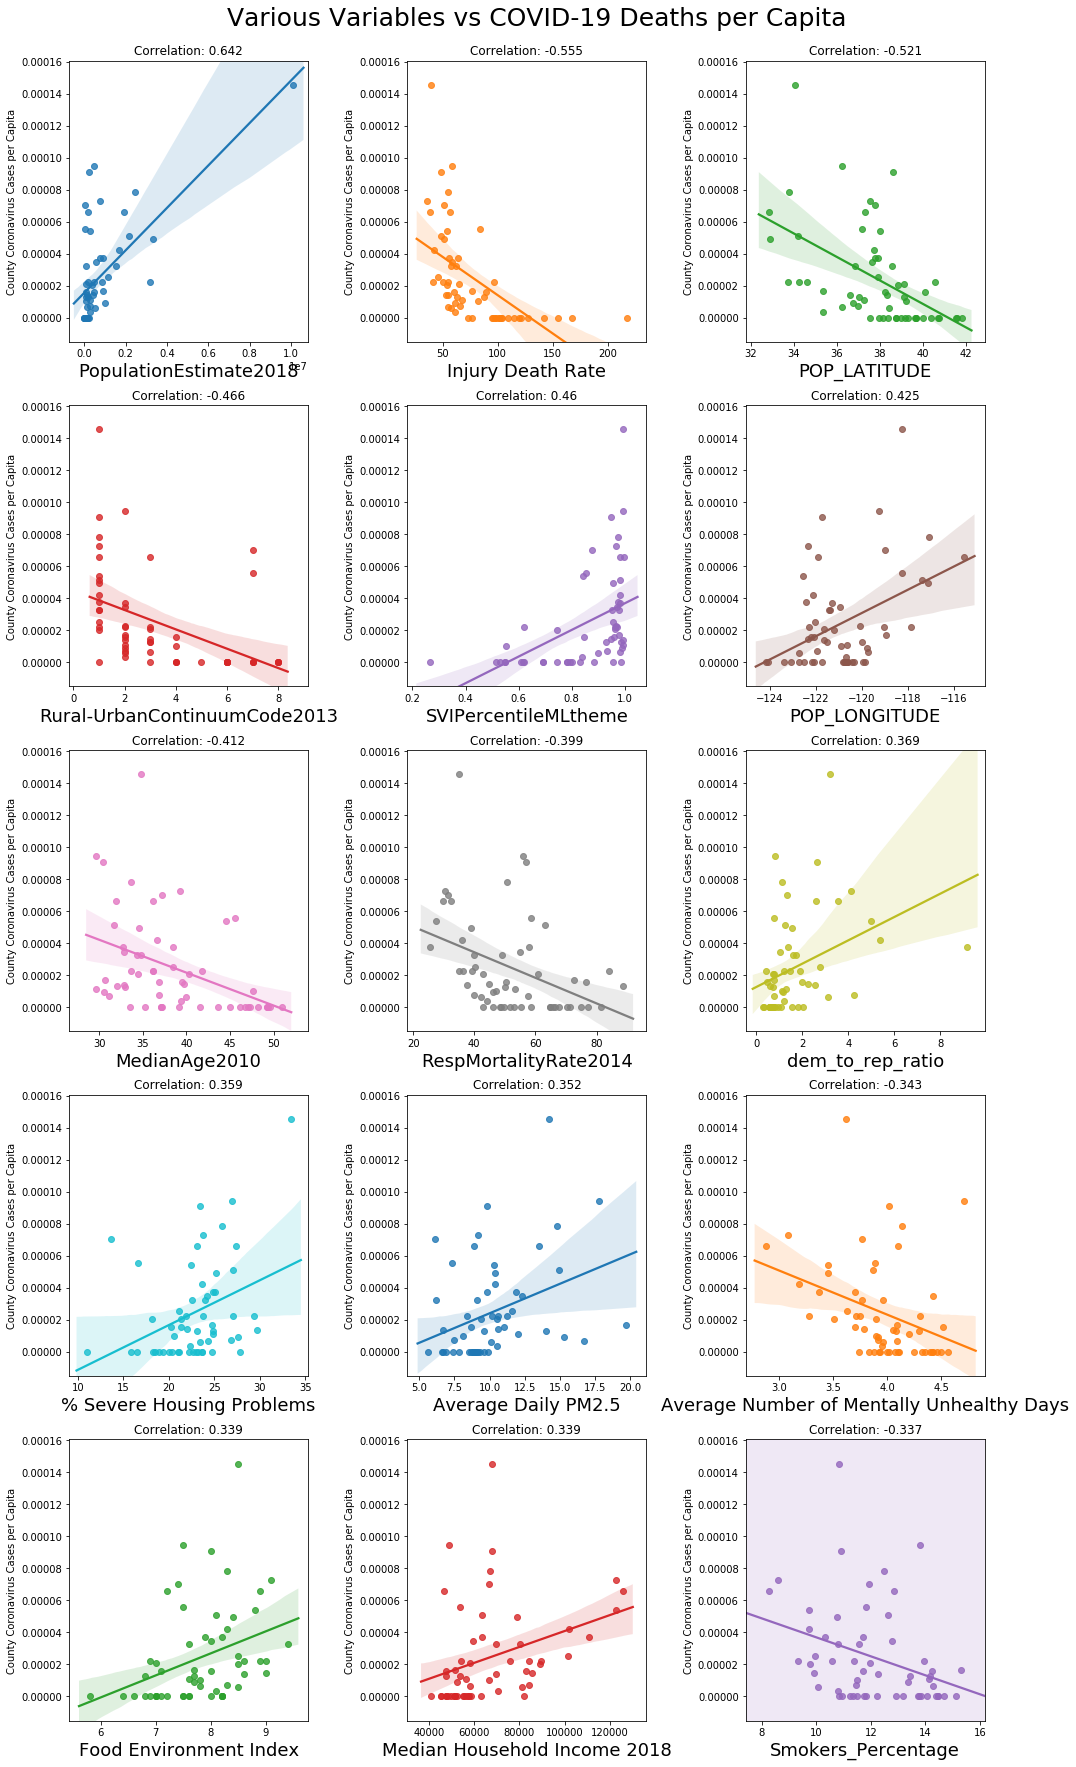

In [431]:
#Death Correlations
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_deaths, california_deaths['5/8/20']/california_deaths['PopulationEstimate2018'])
plot_correlations(california_deaths, corr, california_deaths['5/8/20']/california_deaths['PopulationEstimate2018'], title="Various Variables vs COVID-19 Deaths per Capita")

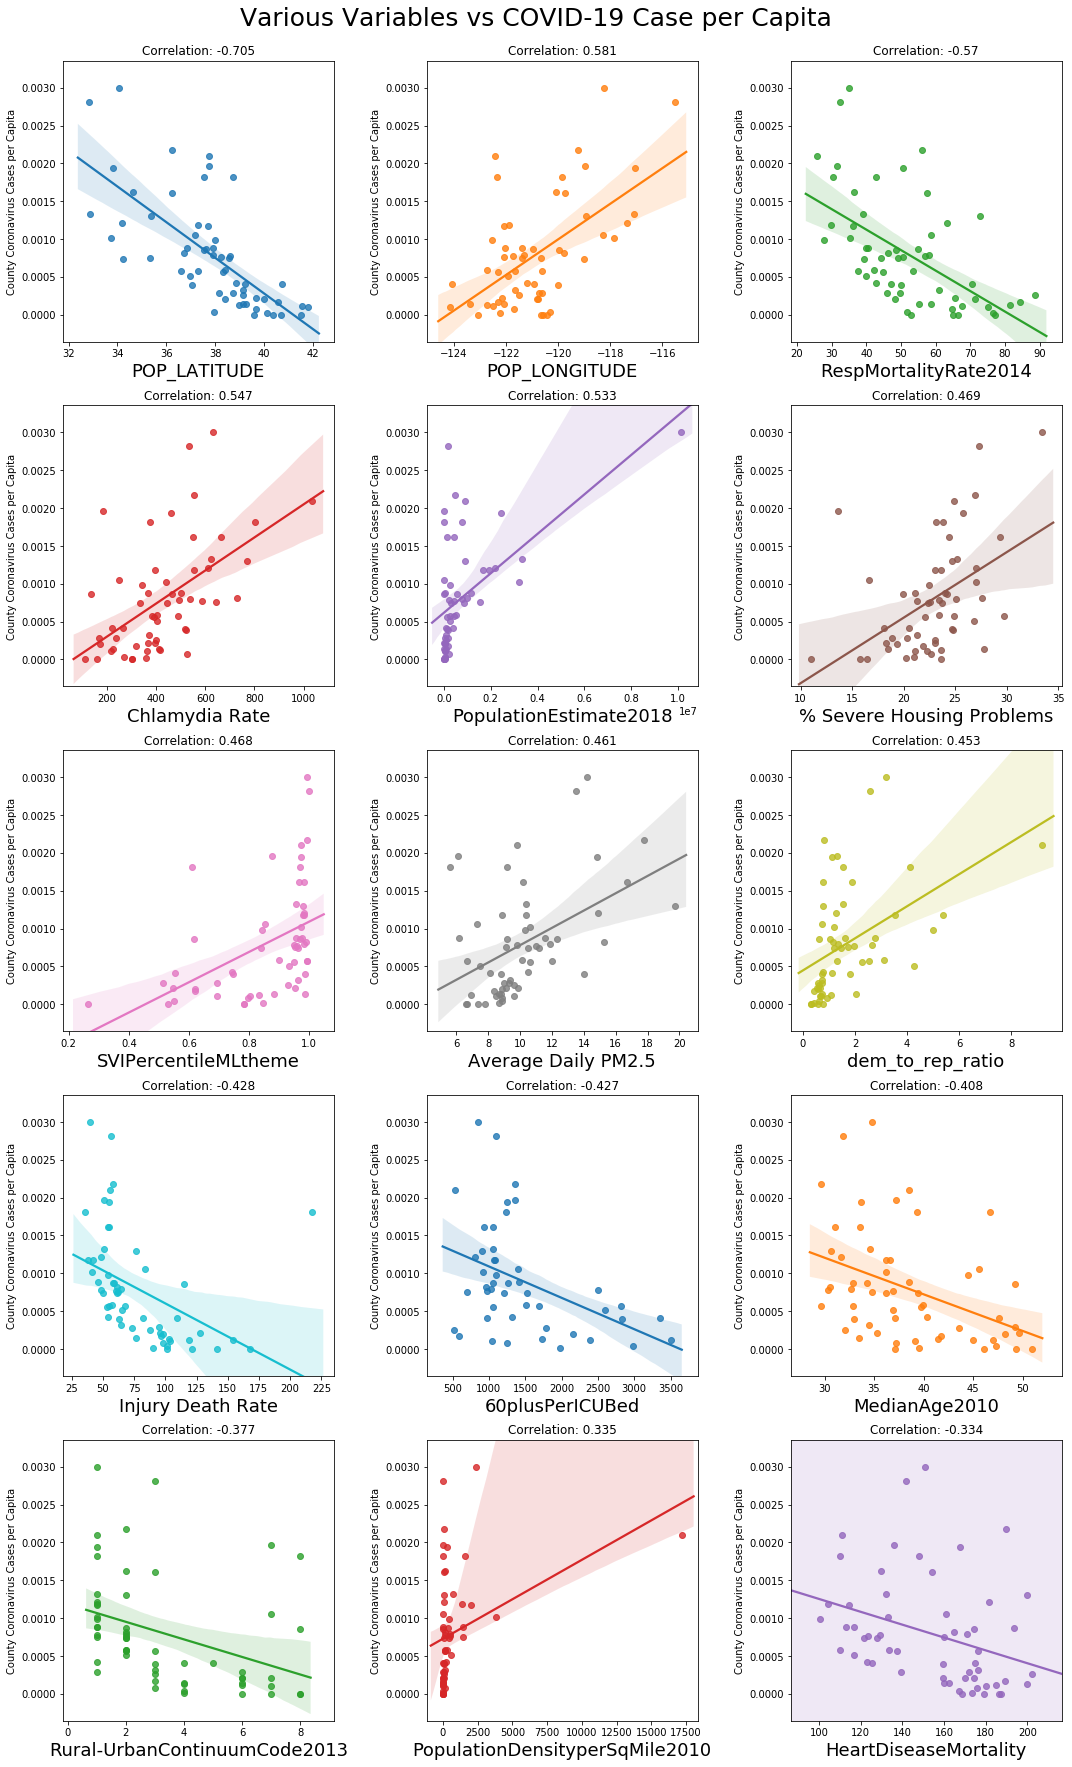

In [432]:
corr, log_normal_corr, log_log_corr, normal_log_corr = find_correlations(california_cases, california_cases['5/8/20']/california_cases['PopulationEstimate2018'])
plot_correlations(california_cases, corr, california_cases['5/8/20']/california_cases['PopulationEstimate2018'], title="Various Variables vs COVID-19 Case per Capita")

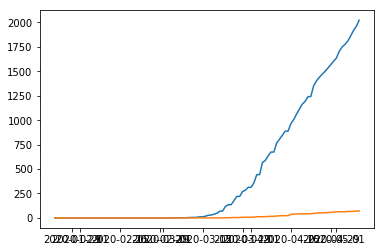

In [105]:
cases.columns.values
dates = cases.columns[11:]
x=pd.to_datetime(dates).values
y=cases[cases['County'] == 'Alameda'][dates].iloc[0].values
sns.lineplot(x=x, y=y)
y=deaths[deaths['County'] == 'Alameda'][dates].iloc[0].values
sns.lineplot(x=x, y=y)